In [1]:
from toolz import partial
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env
from rl_analysis.maya.process import add_area, add_trial_count, add_onset_and_duration,rle
from rl_analysis.util import zscore
from rl_analysis.io.df import exclude_uuids
import pandas as pd
import natsort as ns
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from functools import partial
from glob import glob
import os

In [2]:
setup_plotting_env()

In [4]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
figure_cfg = analysis_config["figures"]

In [3]:
sim_files = os.path.join(
    raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet"
)

In [3]:
load_keys = [
            "mouse_id",
            "predicted_syllable",
            "predicted_syllable (offline)",
            "area (pooled)",
            "date",
            "uuid",
            "cohort",
            "genotype",
            "target_syllable",
            "syllable_group",
            "timestamp",
            "session_number",
            "velocity_3d_mm",
            "feedback_status",

        ]

In [5]:
feedback_df = pd.read_parquet(sim_files,columns = load_keys)

In [6]:
feedback_df[feedback_df.genotype.str.contains("ctrl")]['mouse_id'].unique().tolist()

['snc-dls-ctrl-6',
 'vta-nacc-ctrl-6',
 '10',
 '1527',
 '1561',
 '197',
 '200',
 '208',
 '209',
 '211',
 'snc-dls-ctrl-7',
 'vta-nacc-ctrl-7']

In [7]:
feedback_df = feedback_df[feedback_df.genotype.str.contains("ctrl")]


In [8]:
feedback_df['mouse_id'].unique()

['snc-dls-ctrl-6', 'vta-nacc-ctrl-6', '10', '1527', '1561', ..., '208', '209', '211', 'snc-dls-ctrl-7', 'vta-nacc-ctrl-7']
Length: 12
Categories (41, object): ['3155', 'snc-dls-ctrl-6', 'vta-nacc-ctrl-6', '3440', ..., 'dls-ai32jr-4', 'dls-ai32jr-5', 'dlight-chrimson-8', 'dlight-chrimson-9']

In [9]:
feedback_df = add_area(feedback_df)
feedback_df = feedback_df[~feedback_df.uuid.isin(exclude_uuids)]
feedback_df = add_onset_and_duration(feedback_df)

In [10]:
feedback_df['area (pooled)'].unique()

array(['ctrl'], dtype=object)

In [11]:
data = feedback_df[(feedback_df.session_number < 1) &
                    (feedback_df.syllable_group==2)
][['predicted_syllable','dur','area (pooled)','mouse_id','uuid','onset','cohort','timestamp']]

In [12]:
tmp = data[data.mouse_id.isin(['snc-dls-ctrl-6',
                                       'vta-nacc-ctrl-6'])]

In [13]:
data = data.drop(tmp[tmp.cohort.isin([5,12])].index) #patch some controls

In [14]:
data = data[data.onset==True]

In [15]:
data['dur_z'] = data.groupby(['uuid','mouse_id'])['dur'].transform(zscore)

In [16]:
data.uuid.nunique()/data.mouse_id.nunique()

2.0

In [17]:
#rle usage
to_plot = pd.DataFrame(data.groupby(['uuid','mouse_id'])['predicted_syllable'].value_counts())
to_plot = to_plot.rename(columns={'predicted_syllable':'usage_rle'}).reset_index()

In [18]:
to_plot['usage_rle_z'] = to_plot.groupby(['uuid','mouse_id'])['usage_rle'].transform(zscore)

In [19]:
#add mean zscored duration per syllable
to_plot = to_plot.merge(data.groupby(['uuid','mouse_id','predicted_syllable'])['dur_z'].mean().reset_index(), on=['uuid','mouse_id','predicted_syllable'])


In [20]:
to_plot = to_plot.groupby(['mouse_id','predicted_syllable']).mean().reset_index()

/tmp/ipykernel_22082/1467968866.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_plot = to_plot.groupby(['mouse_id','predicted_syllable']).mean().reset_index()


In [21]:
import yaml,toml

In [22]:
sylls_to_use = "/home/markowitzmeister_gmail_com/jeff_win_share/reinforcement_data/_final_test/_data/_to_upload_zenodo/optoda_intermediate_results/syllable_stats_online.toml"

In [23]:
sylls_to_use = toml.load(sylls_to_use)

In [24]:
sylls = [int(x) for x in sylls_to_use['syllable_to_sorted_idx'].keys()][:40]

In [25]:
len(sylls)

40

In [26]:
from scipy.stats import sem

In [27]:

means = to_plot[to_plot.predicted_syllable.isin(sylls)].groupby(
    'predicted_syllable')['usage_rle_z','dur_z'].mean().rename(columns = {"usage_rle_z":"usage_rle_z_mean",
                                                               "dur_z": "dur_z_mean"})

sems = to_plot[to_plot.predicted_syllable.isin(sylls)].groupby(
    'predicted_syllable')['usage_rle_z','dur_z'].sem().rename(columns = {"usage_rle_z":"usage_rle_z_sem",
                                                               "dur_z": "dur_z_sem"})

to_plot = pd.merge(sems,means, on='predicted_syllable')


/tmp/ipykernel_22082/3852221203.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = to_plot[to_plot.predicted_syllable.isin(sylls)].groupby(
/tmp/ipykernel_22082/3852221203.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sems = to_plot[to_plot.predicted_syllable.isin(sylls)].groupby(


In [28]:
targets = [27,20,17,76,59,30]

In [29]:
to_plot['target'] = np.where(to_plot.index.isin(targets),1,0)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

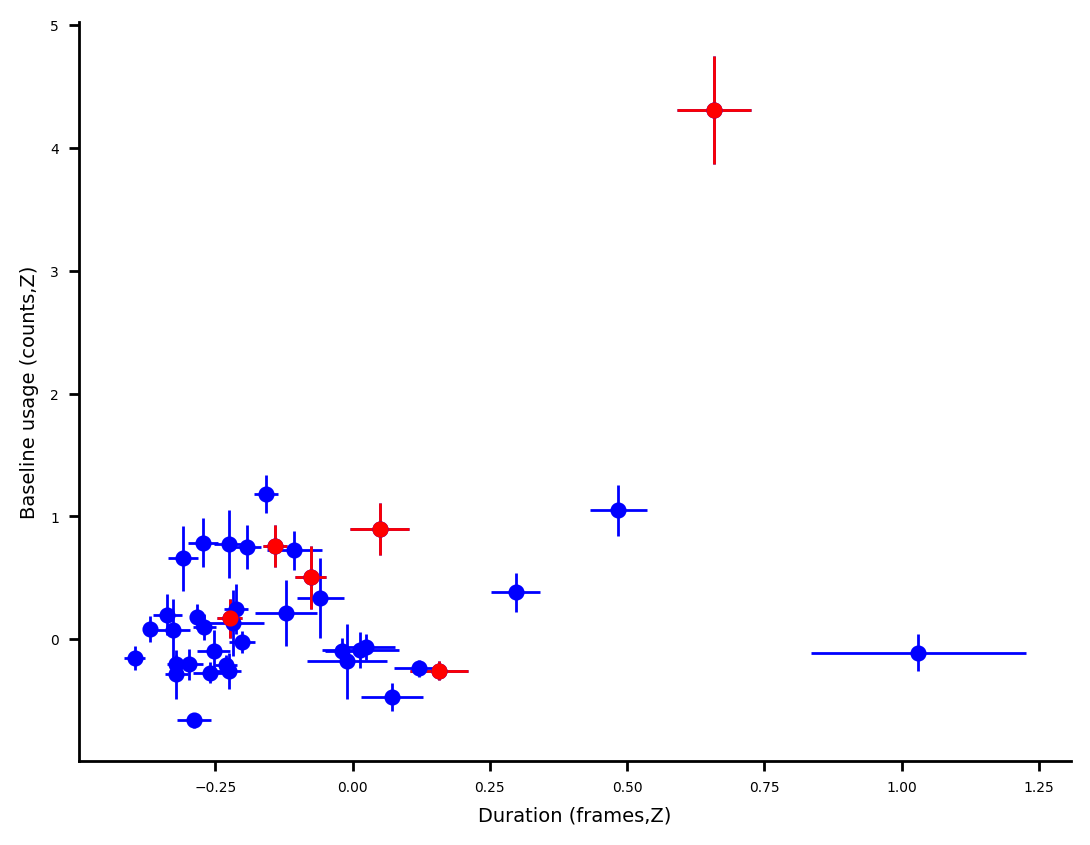

In [30]:
plt.errorbar(x=to_plot['dur_z_mean'],
            y = to_plot['usage_rle_z_mean'],
            xerr = to_plot['dur_z_sem'],
            yerr = to_plot['usage_rle_z_sem'],
            ls='none',
            marker='o',color='b')

blue = to_plot[to_plot.target==1]
plt.errorbar(x=blue['dur_z_mean'],
            y = blue['usage_rle_z_mean'],
            xerr = blue['dur_z_sem'],
            yerr = blue['usage_rle_z_sem'],
            ls='none',
            marker='o',color='r')


plt.xlabel('Duration (frames,Z)')
plt.ylabel('Baseline usage (counts,Z)')
sns.despine()
